<div class="alert alert-block alert-danger">   
    <h1 style="text-align: center; color:purple;">Encoding, ColumnTransformer, Pipeline</h1>
    <h3 style="text-align: center; color:purple;">(Data Preprocessing | Model Building | Prediction)</h3>
</div>

Data preprocessing in Machine Learning is a crucial step and refers to the technique of preparing (cleaning and organizing) the data to make it suitable for a building and training Machine Learning models.

Machine learning models require all input variables to be numeric. So, you must encode categorical data to numbers before fitting and evaluating a model.

Different methods can be used to encode categorical features and building a machine learning model. We will use "Health Insurance Charges" data for encoding and model building. 

### CONTENT
<a id='content'></a>


- 1) [Data Review](#data)


- 2) [Data pre-processing, Model Building and Prediction (pandas get_dummies)](#phase1)<br>
    * 2.1 [encoding and scaling (pandas get_dummies)](#pre-process1)    
    * 2.2 [simple linear regression model building](#model1)
    * 2.3 [prediction](#prediction1-1)
    * 2.4 [prediction with pickle](#prediction1-2)
    
    
- 3) [Data pre-processing, Model Building and Prediction With Encoders, ColumnTransformer and Pipeline](#phase2)
    * 3.1 [encoding with OrdinalEncoder and OneHotEncoder](#pre-process2)
    * 3.2 [how to use encoders in column transformer](#pre-process3)
    * 3.3 [building a regression model with ColumnTransformer and Pipeline](#model2)
    * 3.4 [building a regression model with make_column_transformer and make_pipeline](#model3)
    * 3.5 [prediction](#prediction2-1)
    * 3.6 [prediction with pickle](#prediction2-2)
    
    
- 4) [Grid Search with Pipeline and make_pipeline](#phase3)
    * 4.1 [ColumnTransformer and Pipeline](#GSearch-1)
    * 4.2 [make_column_transformer and make_pipeline](#GSearch-2)
    
    
- 5) [Conclusion](#conc)

<div class="alert alert-block alert-success">
    
<b>1. Data Review<a id='data'></a></b>
    
</div>

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from yellowbrick.style import set_palette
set_palette('flatui')

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
data=pd.read_csv("health_insurance_charges.csv")
data.head()

,age,sex,bmi,smoker,region,children,charges
0,21,male,25.745,no,northeast,2,3279.869
1,37,female,25.744,yes,southeast,3,21454.494
2,18,male,30.030,no,southeast,1,1720.354
3,37,male,30.677,no,northeast,3,6801.438
4,58,male,32.010,no,southeast,1,11946.626


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2500 non-null   int64  
 1   sex       2500 non-null   object 
 2   bmi       2500 non-null   float64
 3   smoker    2500 non-null   object 
 4   region    2500 non-null   object 
 5   children  2500 non-null   int64  
 6   charges   2500 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 136.8+ KB


In [4]:
data.shape, data.size

((2500, 7), 17500)

In [5]:
data.isnull().sum().any(), \
data.duplicated().any()

(False, False)

In [6]:
data.describe()

,age,bmi,children,charges
count,2500.000,2500.000,2500.000,2500.000
mean,39.007,30.575,2.488,12679.312
std,12.264,5.390,1.707,10593.270
min,18.000,15.960,0.000,1121.874
25%,29.000,26.718,1.000,5612.781
50%,39.000,30.200,2.000,9455.047
75%,49.000,34.046,4.000,14440.628
max,64.000,53.130,5.000,63770.428


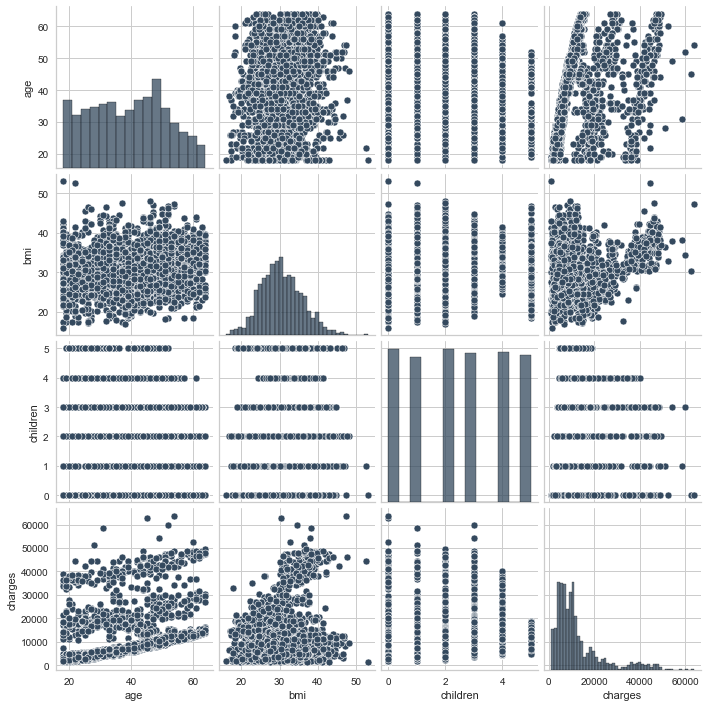

In [7]:
sns.pairplot(data);

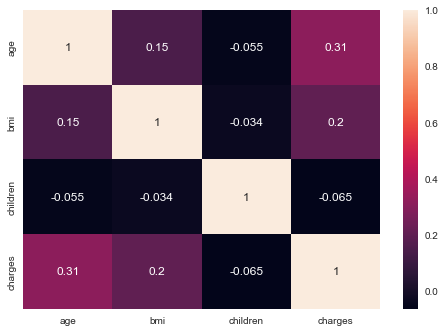

In [8]:
sns.heatmap(data.corr(), annot=True);

***converting age column to categorical (ordinal) data***

While this is not required, it is applied to show the use of the OrdinalEncoder and ColumnTransformer.

In [9]:
np.sort(data.age.unique())

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64], dtype=int64)

In [10]:
data['age'] = data.age.apply(lambda x: '15-20' if x < 21 else '21-30' if x < 31 else '31-40' if x < 41 else '41-50' if x < 51
                                    else '51-60' if x < 61 else '60-65')

In [11]:
data['age'].value_counts()

41-50    695
31-40    600
21-30    539
51-60    389
15-20    189
60-65     88
Name: age, dtype: int64

<div class="alert alert-block alert-success">
    
<b>2. Data pre-processing, Model Building and Prediction (pandas get_dummies)<a id='phase1'></a></b>
    
</div>

[CONTENT](#content)

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
df = data.copy()

## 2.1 encoding and scaling (pandas get_dummies)
<a id='pre-process1'></a>

***encoding for nominal features***

In [14]:
# In the next part, OrdinalEncoder will be used to convert categorical data to numeric.
# note the order of categories when converting to numeric for ordinal data.

df.age.replace(np.sort(df.age.unique()), range(df.age.nunique()), inplace=True)

In [15]:
df.age.value_counts()

3    695
2    600
1    539
4    389
0    189
5     88
Name: age, dtype: int64

***encoding for ordinal features***

When using dummy variables in a regression model, you should be careful of the Dummy Variable Trap. The Dummy Variable Trap is a scenario in which two or more variables are highly correlated; in simple terms one variable can be predicted from the others. The solution to the dummy variable trap is to drop one of the categorical variables.

(use dummy variable encoding with drop_first=True in a regression model)

In [16]:
df = pd.get_dummies(df, drop_first=True)

In [17]:
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,1,25.745,2,3279.869,1,0,0,0,0
1,2,25.744,3,21454.494,0,1,0,1,0
2,0,30.030,1,1720.354,1,0,0,1,0
3,2,30.677,3,6801.438,1,0,0,0,0
4,4,32.010,1,11946.626,1,0,0,1,0


## 2.2 simple linear regression model building
<a id='model1'></a>

***splitting data into training and testing sets***

In [18]:
X = df.drop('charges', axis=1)
y = df['charges']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [20]:
X_train.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
1026,3,29.096,1,0,0,0,0,1
1459,3,39.175,4,0,0,1,0,0
2164,3,30.603,4,1,1,0,0,0
2098,3,24.644,5,0,0,0,1,0
852,0,53.130,0,1,0,0,1,0


In [21]:
print("Train features shape : ", X_train.shape)
print("Test features shape  : ", X_test.shape)

Train features shape :  (2000, 8)
Test features shape  :  (500, 8)


***scaling***

In [22]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
pd.DataFrame(X_train_scaled[:5])

,0,1,2,3,4,5,6,7
0,0.600,0.338,0.200,0.000,0.000,0.000,0.000,1.000
1,0.600,0.616,0.800,0.000,0.000,1.000,0.000,0.000
2,0.600,0.380,0.800,1.000,1.000,0.000,0.000,0.000
3,0.600,0.216,1.000,0.000,0.000,0.000,1.000,0.000
4,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000


***model building***

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
model = LinearRegression()
model.fit(X_train_scaled, y_train) #use scaled X_train

LinearRegression()

In [26]:
y_pred = model.predict(X_test_scaled) #use scaled X_test

R2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'R2 score   : {R2:.3f}')
print(f'rmse score : {rmse:.2f}')

R2 score   : 0.752
rmse score : 5275.00


In [27]:
abs(cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='neg_root_mean_squared_error').mean())

5825.597221266161

In [28]:
pd.DataFrame({'Actual': y_test[:5], 'Prediction': model.predict(X_test_scaled)[:5]})

,Actual,Prediction
2415,15181.169,10481.138
218,10104.560,12096.514
469,3292.530,6491.600
1166,42656.691,35926.803
254,12026.095,11548.323


## 2.3 prediction
<a id='prediction1-1'></a>

In [29]:
final_scaler = MinMaxScaler()
final_scaler.fit(X)
X_scaled = final_scaler.transform(X)

In [30]:
final_model = LinearRegression()
final_model.fit(X_scaled,y)

LinearRegression()

In [31]:
df_new = pd.DataFrame({
        'age': ['15-20', '31-40', '60-65', '31-40', '21-30'],
        'sex': ['male', 'male', 'female', 'female', 'male'],
        'bmi': [25.754, 34.313, 48.700, 19.111, 40.642],
        'smoker': ['yes', 'no', 'no', 'yes', 'yes'],
        'region': ['southwest', 'northeast', 'northeast', 'southeast', 'northwest'],
        'children': [2, 0, 4, 4, 1],
})

df_new

,age,sex,bmi,smoker,region,children
0,15-20,male,25.754,yes,southwest,2
1,31-40,male,34.313,no,northeast,0
2,60-65,female,48.700,no,northeast,4
3,31-40,female,19.111,yes,southeast,4
4,21-30,male,40.642,yes,northwest,1


In [32]:
df_new.age.replace(['15-20', '21-30', '31-40', '60-65'], [0,1,2,5], inplace=True)
# Encoding should be performed carefully when transformers are not used

In [33]:
df_new = pd.get_dummies(df_new)
df_new

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0,25.754,2,0,1,0,1,0,0,0,1
1,2,34.313,0,0,1,1,0,1,0,0,0
2,5,48.700,4,1,0,1,0,1,0,0,0
3,2,19.111,4,1,0,0,1,0,0,1,0
4,1,40.642,1,0,1,0,1,0,1,0,0


In [34]:
df_new = df_new.reindex(columns=X.columns, fill_value=0)
df_new

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,0,25.754,2,1,1,0,0,1
1,2,34.313,0,1,0,0,0,0
2,5,48.700,4,0,0,0,0,0
3,2,19.111,4,0,1,0,1,0
4,1,40.642,1,1,1,1,0,0


In [35]:
df_new_scaled = final_scaler.transform(df_new)
df_new_scaled

array([[0.        , 0.26349206, 0.4       , 1.        , 1.        ,
        0.        , 0.        , 1.        ],
       [0.4       , 0.49375841, 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        ],
       [1.        , 0.88081786, 0.8       , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.4       , 0.08477267, 0.8       , 0.        , 1.        ,
        0.        , 1.        , 0.        ],
       [0.2       , 0.66403013, 0.2       , 1.        , 1.        ,
        1.        , 0.        , 0.        ]])

In [36]:
final_model.predict(df_new_scaled)

array([24516.31586475, 10349.72657311, 22420.18437239, 27815.51386477,
       30793.77249807])

## 2.4 prediction with pickle
<a id='prediction1-2'></a>

In [37]:
import pickle
pickle.dump(final_scaler, open('final_scaler.pkl','wb'))
pickle.dump(final_model, open('final_model.pkl', 'wb'))

In [38]:
df_new = pd.DataFrame({
        'age': ['15-20', '31-40', '60-65', '31-40', '21-30'],
        'sex': ['male', 'male', 'female', 'female', 'male'],
        'bmi': [25.754, 34.313, 48.700, 19.111, 40.642],
        'smoker': ['yes', 'no', 'no', 'yes', 'yes'],
        'region': ['southwest', 'northeast', 'northeast', 'southeast', 'northwest'],
        'children': [2, 0, 4, 4, 1],
})

df_new

,age,sex,bmi,smoker,region,children
0,15-20,male,25.754,yes,southwest,2
1,31-40,male,34.313,no,northeast,0
2,60-65,female,48.700,no,northeast,4
3,31-40,female,19.111,yes,southeast,4
4,21-30,male,40.642,yes,northwest,1


In [39]:
df_new.age.replace(['15-20', '21-30', '31-40', '60-65'], [0,1,2,5], inplace=True)
# Encoding should be performed carefully when transformers are not used

In [40]:
df_new = pd.get_dummies(df_new).reindex(columns=X.columns, fill_value=0)
df_new

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,0,25.754,2,1,1,0,0,1
1,2,34.313,0,1,0,0,0,0
2,5,48.700,4,0,0,0,0,0
3,2,19.111,4,0,1,0,1,0
4,1,40.642,1,1,1,1,0,0


In [41]:
scaler = pickle.load(open('final_scaler.pkl', 'rb'))
model = pickle.load(open('final_model.pkl', 'rb'))

In [42]:
df_new_scaled = scaler.transform(df_new)

In [43]:
model.predict(df_new_scaled)

array([24516.31586475, 10349.72657311, 22420.18437239, 27815.51386477,
       30793.77249807])

<div class="alert alert-block alert-success">
    
<b>3. Data pre-processing, Model Building and Prediction With Encoders, ColumnTransformer and Pipeline<a id='phase2'></a></b>
    
</div>

[CONTENT](#content)

In [44]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

In [45]:
df = data.copy()

## 3.1 encoding with OrdinalEncoder and OneHotEncoder

<a id='pre-process2'></a>

Nominal data is classified without a natural order or rank, whereas ordinal data has a predetermined or natural order.

Two common ways to encode categorical features:

* OneHotEncoder for unordered (nominal) data 
* OrdinalEncoder for ordered (ordinal) data

In some cases (especially when modeling with tree-based algorithms), nominal data can be encoded with an ordinal encoder 

NOTE:

* OneHotEncoder and OrdinalEncoder encodes target values according to their alphabetic order.
* When using one hot encoder in a pipeline, it may need to be used with a column transformer.

***Ordinal Encoding***

In [46]:
np.sort(df.age.unique())

array(['15-20', '21-30', '31-40', '41-50', '51-60', '60-65'], dtype=object)

In [47]:
enc = OrdinalEncoder(categories=[np.sort(df.age.unique())])
df['age'] = enc.fit_transform(df[['age']])

In [48]:
df.head()

,age,sex,bmi,smoker,region,children,charges
0,1.000,male,25.745,no,northeast,2,3279.869
1,2.000,female,25.744,yes,southeast,3,21454.494
2,0.000,male,30.030,no,southeast,1,1720.354
3,2.000,male,30.677,no,northeast,3,6801.438
4,4.000,male,32.010,no,southeast,1,11946.626


In [49]:
df.age.value_counts()

3.000    695
2.000    600
1.000    539
4.000    389
0.000    189
5.000     88
Name: age, dtype: int64

***One Hot Encoding***

OneHotEncoder creates a binary column for each category and returns a sparse matrix or dense array (depending on the sparse parameter)

In [50]:
cat_features = ['sex', 'smoker', 'region']

In [51]:
ohe = OneHotEncoder(drop='first')  
ohe.fit_transform(df[cat_features]).toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0.],
       [1., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1.]])

In [52]:
ohe = OneHotEncoder(drop='first', sparse=False)  #sparse=False returns an array
ohe.fit_transform(df[cat_features])

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0.],
       [1., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1.]])

## 3.2 how to use encoders in column transformer
<a id='pre-process3'></a>

ColumnTransformer allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space. [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)

You can use column transformer to do preprocessing all of dataframe's columns at the same time without doing it in pandas.

In [53]:
df = data.copy()

In [54]:
{column: list(df[column].unique()) for column in df.select_dtypes('O').columns}

{'age': ['21-30', '31-40', '15-20', '51-60', '41-50', '60-65'],
 'sex': ['male', 'female'],
 'smoker': ['no', 'yes'],
 'region': ['northeast', 'southeast', 'northwest', 'southwest']}

In [55]:
cat_nominal = ['sex', 'smoker', 'region']

ct = ColumnTransformer(transformers=[
        ('encoder_ordinal', OrdinalEncoder(categories=[np.sort(df.age.unique())]), ['age']),  #for ordinal features
        ('encoder_nominal', OneHotEncoder(drop='first'), cat_nominal)                         #for nominal features
], remainder='passthrough')
# remainder='passthrough' ===> returns all features of the data frame

In [56]:
pd.DataFrame(ct.fit_transform(df))

,0,1,2,3,4,5,6,7,8
0,1.000,1.000,0.000,0.000,0.000,0.000,25.745,2.000,3279.869
1,2.000,0.000,1.000,0.000,1.000,0.000,25.744,3.000,21454.494
2,0.000,1.000,0.000,0.000,1.000,0.000,30.030,1.000,1720.354
3,2.000,1.000,0.000,0.000,0.000,0.000,30.677,3.000,6801.438
4,4.000,1.000,0.000,0.000,1.000,0.000,32.010,1.000,11946.626
...,...,...,...,...,...,...,...,...,...
2495,2.000,1.000,0.000,0.000,1.000,0.000,27.555,4.000,5889.104
2496,2.000,1.000,0.000,0.000,0.000,0.000,30.322,3.000,6788.534
2497,4.000,0.000,0.000,1.000,0.000,0.000,36.180,2.000,12401.747
2498,3.000,1.000,0.000,1.000,0.000,0.000,36.430,3.000,10376.295


## 3.3 building a regression model with ColumnTransformer and Pipeline
<a id='model2'></a>

***splitting data into training and testing sets***

In [57]:
df.keys()  # df.columns

Index(['age', 'sex', 'bmi', 'smoker', 'region', 'children', 'charges'], dtype='object')

In [58]:
X = df.drop('charges', axis=1)
y = df['charges']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [60]:
X_train.head()

,age,sex,bmi,smoker,region,children
1026,41-50,female,29.096,no,southwest,1
1459,41-50,female,39.175,no,northwest,4
2164,41-50,male,30.603,yes,northeast,4
2098,41-50,female,24.644,no,southeast,5
852,15-20,male,53.130,no,southeast,0


***model building***

In [61]:
# categorical (nominal) features
cat_nominal = ['sex', 'smoker', 'region']

preprocessor = ColumnTransformer(transformers=[
        ('encoder_ordinal', OrdinalEncoder(categories=[np.sort(df.age.unique())]), ['age']),
        ('encoder_nominal', OneHotEncoder(drop='first'), cat_nominal)
], remainder='passthrough')

# pipeline chains steps together sequentially
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler()),
    ('regressor', LinearRegression())
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder_ordinal',
                                                  OrdinalEncoder(categories=[array(['15-20', '21-30', '31-40', '41-50', '51-60', '60-65'], dtype=object)]),
                                                  ['age']),
                                                 ('encoder_nominal',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('scaler', MinMaxScaler()), ('regressor', LinearRegression())])

In [62]:
y_pred = model.predict(X_test)

R2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'R2 score   : {R2:.3f}')
print(f'rmse score : {rmse:.2f}')

R2 score   : 0.752
rmse score : 5275.00


In [63]:
abs(cross_val_score(model, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error').mean())

5825.59722126616

In [64]:
pd.DataFrame({'Actual': y_test[:5], 'Prediction': model.predict(X_test)[:5]})

,Actual,Prediction
2415,15181.169,10481.138
218,10104.560,12096.514
469,3292.530,6491.600
1166,42656.691,35926.803
254,12026.095,11548.323


## 3.4 building a regression model with make_column_transformer and make_pipeline
<a id='model3'></a>

**ColumnTransformer  |  make_column_transformer**

* There is no such major difference between the two. They both give the same result.
* ColumnTransformer uses a list of a tuple with a name and make_column_transformer is just a tuple without a name. (Name given to tuple is helpful when we use Gridsearchcv or Randomsearchcv)
* make_column_transformer does not allow weighting with transformer_weights.

**pipeline | make_pipeline**

with Pipeline:
  
* names are explicit, you don't have to figure them out if you need them; 
* name doesn't change if you change estimator/transformer used in a step, e.g. if you replace LogisticRegression() with LinearSVC() you can still use 'clf__C'.
      
make_pipeline:
  
* shorter and more readable; 
* lowercase of the estimator's name must be used when we use GridSearchCV

In [65]:
lr_model = LinearRegression()
scaler = MinMaxScaler()

column_trans = make_column_transformer(
    (OrdinalEncoder(categories=[np.sort(df.age.unique())]), ['age']),
    (OneHotEncoder(drop='first'), ['sex', 'smoker', 'region']),
remainder='passthrough')

model = make_pipeline(column_trans, scaler, lr_model)

model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[array(['15-20', '21-30', '31-40', '41-50', '51-60', '60-65'], dtype=object)]),
                                                  ['age']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

In [66]:
y_pred = model.predict(X_test)

R2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'R2 score   : {R2:.3f}')
print(f'rmse score : {rmse:.2f}')

R2 score   : 0.752
rmse score : 5275.00


In [67]:
abs(cross_val_score(model, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error').mean())

5825.59722126616

In [68]:
pd.DataFrame({'Actual': y_test[:5], 'Prediction': model.predict(X_test)[:5]})

,Actual,Prediction
2415,15181.169,10481.138
218,10104.560,12096.514
469,3292.530,6491.600
1166,42656.691,35926.803
254,12026.095,11548.323


## 3.5 prediction
<a id='prediction2-1'></a>

In [69]:
cat_nominal = ['sex', 'smoker', 'region']

preprocessor = ColumnTransformer(transformers=[
        ('encoder_ordinal', OrdinalEncoder(categories=[np.sort(df.age.unique())]), ['age']),
        ('encoder_nominal', OneHotEncoder(drop='first'), cat_nominal)
], remainder='passthrough')

final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler()),
    ('regressor', LinearRegression())
])

final_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder_ordinal',
                                                  OrdinalEncoder(categories=[array(['15-20', '21-30', '31-40', '41-50', '51-60', '60-65'], dtype=object)]),
                                                  ['age']),
                                                 ('encoder_nominal',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('scaler', MinMaxScaler()), ('regressor', LinearRegression())])

In [70]:
df_new = pd.DataFrame({
        'age': ['15-20', '31-40', '60-65', '31-40', '21-30'],
        'sex': ['male', 'male', 'female', 'female', 'male'],
        'bmi': [25.754, 34.313, 48.700, 19.111, 40.642],
        'smoker': ['yes', 'no', 'no', 'yes', 'yes'],
        'region': ['southwest', 'northeast', 'northeast', 'southeast', 'northwest'],
        'children': [2, 0, 4, 4, 1],
})

df_new

,age,sex,bmi,smoker,region,children
0,15-20,male,25.754,yes,southwest,2
1,31-40,male,34.313,no,northeast,0
2,60-65,female,48.700,no,northeast,4
3,31-40,female,19.111,yes,southeast,4
4,21-30,male,40.642,yes,northwest,1


In [71]:
final_model.predict(df_new)

array([24516.31586475, 10349.72657311, 22420.18437239, 27815.51386477,
       30793.77249807])

## 3.6 prediction with pickle
<a id='prediction2-2'></a>

In [72]:
import pickle
pickle.dump(final_model, open('pipe_model.pkl', 'wb'))

In [73]:
df_new = pd.DataFrame({
        'age': ['15-20', '31-40', '60-65', '31-40', '21-30'],
        'sex': ['male', 'male', 'female', 'female', 'male'],
        'bmi': [25.754, 34.313, 48.700, 19.111, 40.642],
        'smoker': ['yes', 'no', 'no', 'yes', 'yes'],
        'region': ['southwest', 'northeast', 'northeast', 'southeast', 'northwest'],
        'children': [2, 0, 4, 4, 1],
})

df_new

,age,sex,bmi,smoker,region,children
0,15-20,male,25.754,yes,southwest,2
1,31-40,male,34.313,no,northeast,0
2,60-65,female,48.700,no,northeast,4
3,31-40,female,19.111,yes,southeast,4
4,21-30,male,40.642,yes,northwest,1


In [74]:
pipe_model = pickle.load(open('pipe_model.pkl', 'rb'))

In [75]:
pipe_model.predict(df_new)

array([24516.31586475, 10349.72657311, 22420.18437239, 27815.51386477,
       30793.77249807])

<div class="alert alert-block alert-success">
    
<b>4. Grid Search with Pipeline and make_pipeline<a id='phase3'></a></b>
    
</div>

[CONTENT](#content)

pipeline allows you to do a grid search or randomize search of both tuning parameters for model and the pre-processing steps.

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

In [77]:
X_train.head()

,age,sex,bmi,smoker,region,children
1026,41-50,female,29.096,no,southwest,1
1459,41-50,female,39.175,no,northwest,4
2164,41-50,male,30.603,yes,northeast,4
2098,41-50,female,24.644,no,southeast,5
852,15-20,male,53.130,no,southeast,0


### 4.1 ColumnTransformer and Pipeline
<a id='GSearch1'></a>

In [78]:
cat_nominal = ['sex', 'smoker', 'region']

preprocessor = ColumnTransformer(transformers=[
        ('encoder_ordinal', OrdinalEncoder(categories=[np.sort(df.age.unique())]), ['age']),
        ('encoder_nominal', OneHotEncoder(drop='first'), cat_nominal)
], remainder='passthrough')

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler()),
    ('regressor', SVR())
])

In [79]:
param_grid = [
        {'regressor__kernel': ['linear'], 'regressor__C': [0.1, 1, 10, 100]},
        {'regressor__kernel': ['poly'], 'regressor__degree':[3, 4, 5], 'regressor__gamma':['auto', 'scale', 1], 
         'regressor__C':[0.1, 1, 10, 100]}
]

%time grid_model = GridSearchCV(estimator=model, param_grid=param_grid, verbose=1, \
                                      scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1).fit(X_train, y_train)

print('\n', grid_model.best_params_)
print('\n', grid_model.best_estimator_)
print('\n', 'Best Score :', grid_model.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Wall time: 15.9 s

 {'regressor__C': 100, 'regressor__degree': 4, 'regressor__gamma': 1, 'regressor__kernel': 'poly'}

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder_ordinal',
                                                  OrdinalEncoder(categories=[array(['15-20', '21-30', '31-40', '41-50', '51-60', '60-65'], dtype=object)]),
                                                  ['age']),
                                                 ('encoder_nominal',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('scaler', MinMaxScaler()),
                ('regressor', SVR(C=100, degree=4, gamma=1, kernel='poly'))])

 Best Score : -5131.3412558527325


In [80]:
y_pred = grid_model.predict(X_test)

R2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'R2 score   : {R2:.3f}')
print(f'rmse score : {rmse:.2f}')

R2 score   : 0.830
rmse score : 4369.10


### 4.2 make_column_transformer and make_pipeline
<a id='GSearch2'></a>

In [81]:
column_trans = make_column_transformer(
    (OrdinalEncoder(categories=[np.sort(df.age.unique())]), ['age']),
    (OneHotEncoder(drop='first'), ['sex', 'smoker', 'region']),
remainder='passthrough')

model = make_pipeline(column_trans, MinMaxScaler(), SVR())

In [82]:
# prefix must be lowercase of the estimator's name

param_grid = [
        {'svr__kernel': ['linear'], 'svr__C': [0.1, 1, 10, 100]},
        {'svr__kernel': ['poly'], 'svr__degree':[3, 4, 5], 'svr__gamma':['auto', 'scale', 1], 'svr__C':[0.1, 1, 10, 100]}
]

%time grid_model = GridSearchCV(estimator=model, param_grid=param_grid, verbose=1, \
                                scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1).fit(X_train, y_train)

print('\n', grid_model.best_params_)
print('\n', grid_model.best_estimator_)
print('\n', 'Best Score :', grid_model.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Wall time: 12.5 s

 {'svr__C': 100, 'svr__degree': 4, 'svr__gamma': 1, 'svr__kernel': 'poly'}

 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[array(['15-20', '21-30', '31-40', '41-50', '51-60', '60-65'], dtype=object)]),
                                                  ['age']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('minmaxscaler', MinMaxScaler()),
                ('svr', SVR(C=100, degree=4, gamma=1, kernel='poly'))])

 Best Score : -5131.3412558527325


In [83]:
y_pred = grid_model.predict(X_test)

R2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'R2 score   : {R2:.3f}')
print(f'rmse score : {rmse:.2f}')

R2 score   : 0.830
rmse score : 4369.10


<div class="alert alert-block alert-success">
    
<b>5. Conclusion<a id='conc'></a></b>
    
</div>

[CONTENT](#content)

Generally, we use pipeline to chain data preprocessing steps with model-building steps together. It allows us to reduce the complexity of the process. And, it allows us to properly cross validate a process, preventing data leakage. 

We use column transformer to preprocess all the data simultaneously and only to the columns we want. In particular, a few steps such as handling missing values, encoding categorical data (in some cases different encoders may need to be used on the same data) and feature scaling can be easily done using column transformer and pipeline.

With our model built with the pipeline, we don't need to reprocess the sample data for every prediction.